# Process the images and build masks

In [36]:
#importations

import os
import SimpleITK as sitk
import numpy as np
import radiomics

from skimage import io as skio
from skimage import img_as_ubyte
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from radiomics import featureextractor, getFeatureClasses
from radiomics import glcm

import cv2


In [37]:
#functions definition

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def mse(y_true,y_pred):
   n = len(y_true)
   mse = np.linalg.norm(y_true - y_pred)
   return mse


def flou(image, kernel_size=3):
    """
    Apply a custom random blur to an image.

    :param image: The input image (NumPy array).
    :param kernel_size: The size of the custom blur kernel (odd number).
    :return: The blurred image.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    kernel = np.random.rand(kernel_size, kernel_size)  # Random coefficients in the kernel
    kernel /= kernel.sum()  # Normalize the kernel to ensure the result is not too bright

    blurred_image = cv2.filter2D(image, -1, kernel)
    return blurred_image

In [38]:
#mask functions:

def crop(im):
  n,p = im.shape
  L = min(n,p)
  return im[int((n-L)/2):int((n+L)/2), int((p-L)/2):int((p+L)/2)]


def makeMask(im,R):
  n,p = im.shape
  mask = np.zeros((n,p))

  O = np.array([int(n/2), int(p/2)])
  #R = 90    #réglé emiriquement

  for i in range(n):
    for j in range(p):
      if ( (np.linalg.norm(np.array([i,j]) - O) < R)):
        mask[i][j] = 1
  return mask


In [45]:
#images importation

im1 = crop(  img_as_ubyte( skio.imread('images/textures/cell.jpg', as_gray = True )    ))
im2 = crop( img_as_ubyte( skio.imread('images/textures/green.jpg', as_gray = True)   ))
im3 = crop( img_as_ubyte( skio.imread('images/textures/red.jpg', as_gray = True)      ))
im4 = crop(img_as_ubyte( skio.imread('images/textures/brain.jpg', as_gray = True)    ))

In [46]:
#masks initialisation

mask1 = makeMask(im1,90)
mask3 = makeMask(im3,420)
mask2 = makeMask(im2,680)


In [47]:
mask4 = np.zeros(im4.shape)
O = (300,400)

mask4[ (O[0]-70):(O[0]+70), (O[1]-70) : (O[1]+70)] = 1

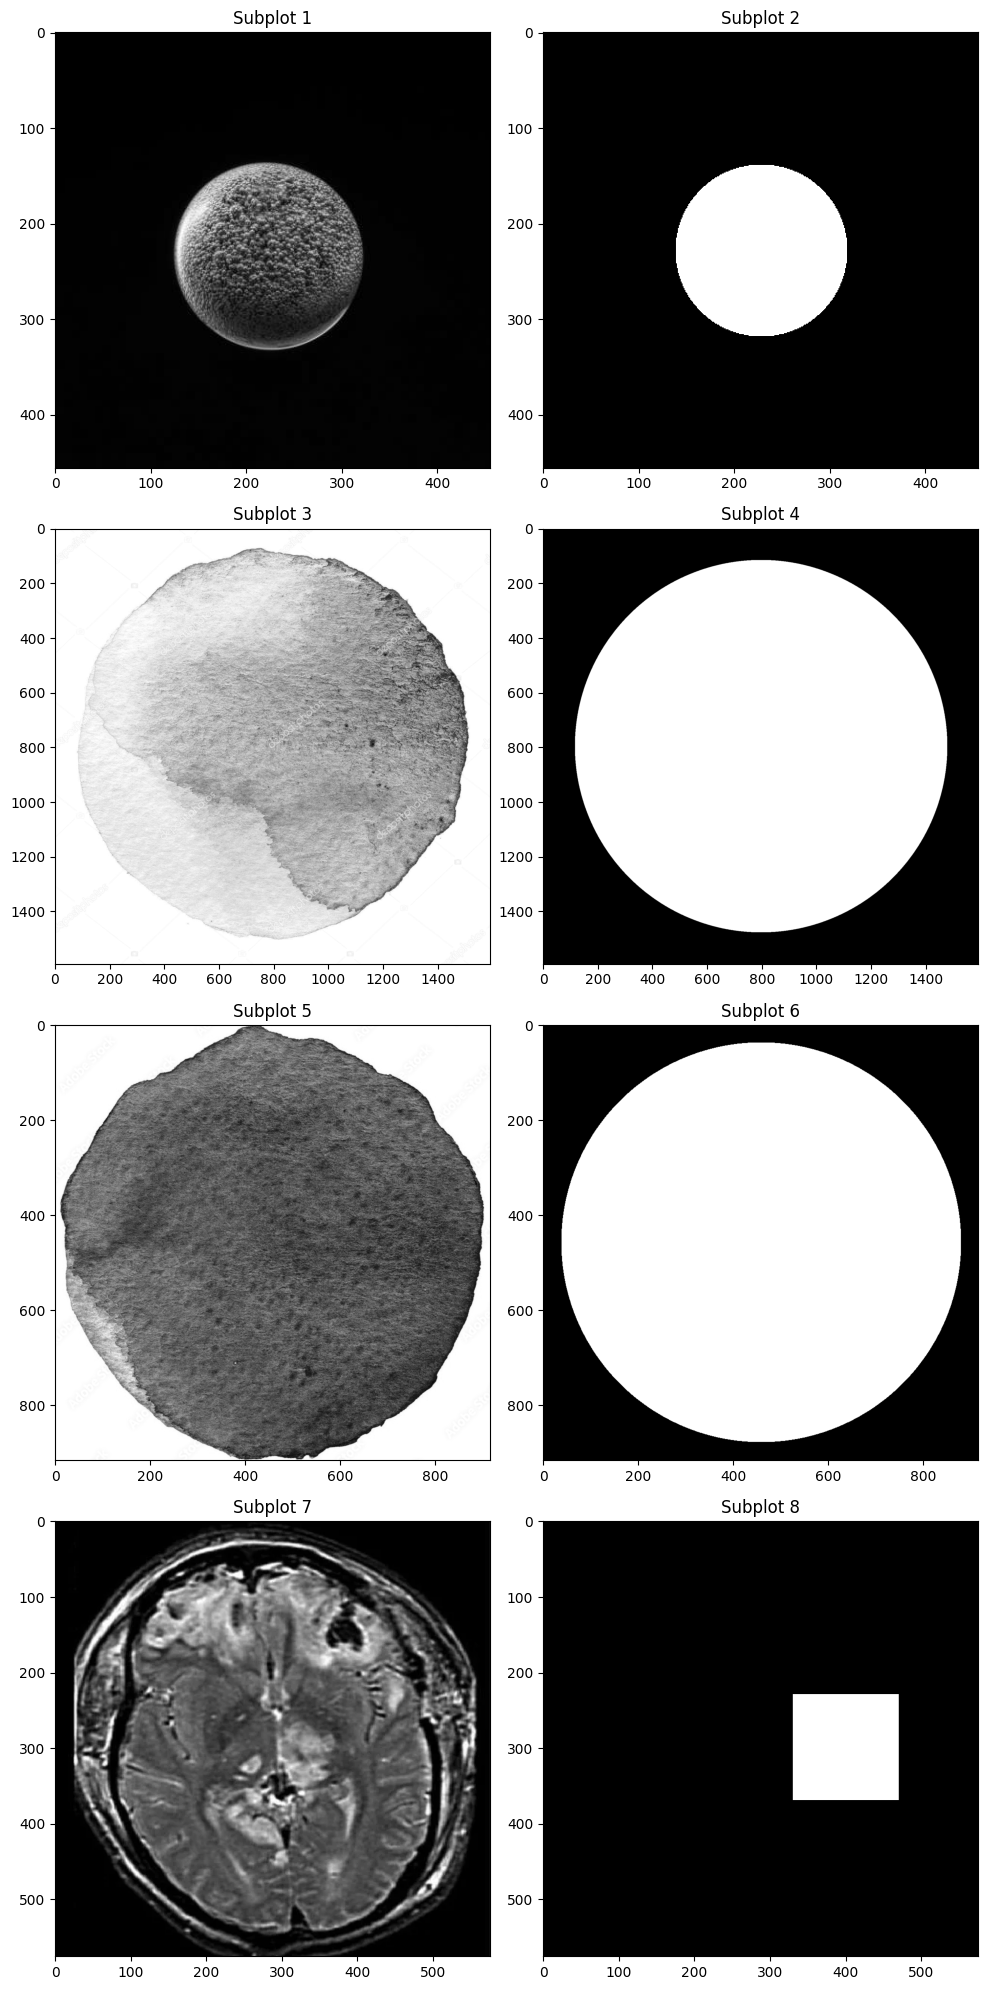

In [48]:
fig, axs = plt.subplots(4, 2,figsize=(10, 20))

# Now, you can plot your data on each subplot
axs[0, 0].imshow(im1, cmap = 'gray')
axs[0, 0].set_title('Subplot 1')
axs[0, 1].imshow(mask1, cmap = 'gray')
axs[0, 1].set_title('Subplot 2')
axs[1, 0].imshow(im2, cmap = 'gray')
axs[1, 0].set_title('Subplot 3')
axs[1, 1].imshow(mask2, cmap = 'gray')
axs[1, 1].set_title('Subplot 4')
axs[2, 0].imshow(im3, cmap = 'gray')
axs[2, 0].set_title('Subplot 5')
axs[2, 1].imshow(mask3, cmap = 'gray')
axs[2, 1].set_title('Subplot 6')
axs[3, 0].imshow(im4, cmap = 'gray')
axs[3, 0].set_title('Subplot 7')
axs[3, 1].imshow(mask4, cmap = 'gray')
axs[3, 1].set_title('Subplot 8')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Deploy the Feature Extractor (GLCM feature)

In [49]:
# Transform image and mask to the supported format
im1_ITK, mask1_ITK  = sitk.GetImageFromArray(im1), sitk.GetImageFromArray(mask1)
im2_ITK, mask2_ITK  = sitk.GetImageFromArray(im2), sitk.GetImageFromArray(mask2)
im3_ITK, mask3_ITK  = sitk.GetImageFromArray(im3), sitk.GetImageFromArray(mask3)
im4_ITK, mask4_ITK  = sitk.GetImageFromArray(im4), sitk.GetImageFromArray(mask4)
#end

In [43]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [44]:
features = np.array(list(result.values()))
args = list(result.keys())

In [10]:
im_noised_list = [noise(im1, 5).astype(np.int32)        for i in range(50)]
im_noised_list +=[noise(im1,br = 20).astype(np.int32)   for i in range(50)]
im_noised_list +=[noise(im1,br = 50).astype(np.int32)   for i in range(50)]


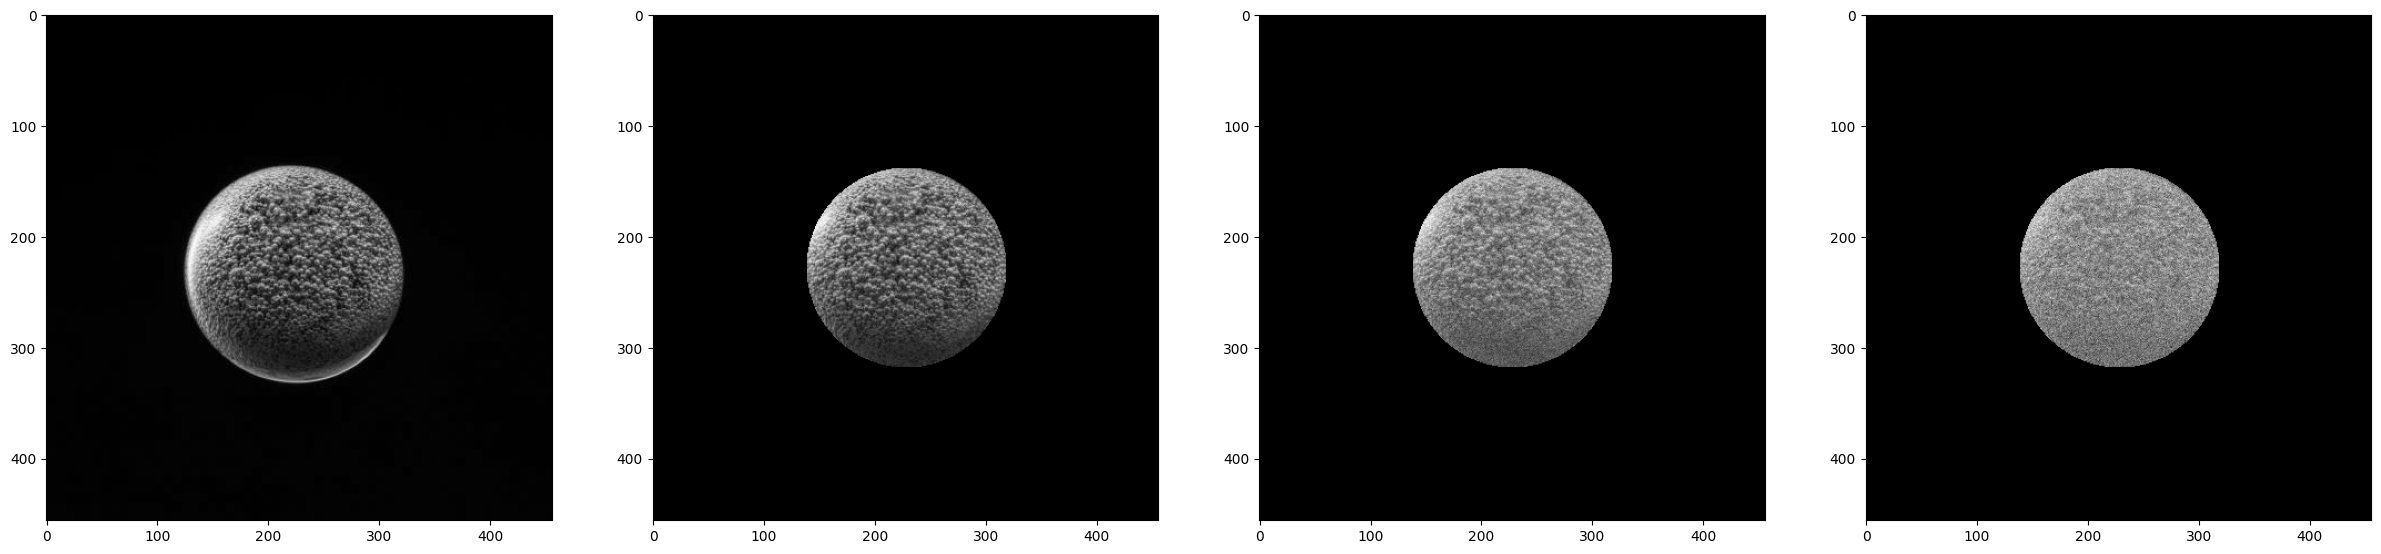

In [71]:
fig, axs = plt.subplots(1,4,figsize=(30, 30))

im_noised_5 = noise(im1,br = 5).astype(np.int32)
im_noised_20 = noise(im1,br = 20).astype(np.int32)
im_noised_50 = noise(im1,br = 50).astype(np.int32)

# Now, you can plot your data on each subplot
axs[0].imshow(im1, cmap = 'gray')
axs[1].imshow( (im_noised_5 - np.min(im_noised_5)) * mask1 , cmap = 'gray')
axs[2].imshow( (im_noised_20 - np.min(im_noised_20)) * mask1, cmap = 'gray')
axs[3].imshow( (im_noised_50 - np.min(im_noised_50)) * mask1, cmap = 'gray')



In [51]:
features_noised = [features]

for i in range(len(im_noised_list)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

#### étude par erreur relatif:

On plotera l'erreur relatif entre la mesure initilae de feature avec la mesure erroné introduit par le bruit : 

$e_{rr} = \frac{f_{réllé} - f_{mesuré}}{f_{réelle}}$

In [52]:
noise_err_1 = np.array([(features_noised[i] - features)/features for i in range(150)])
noise_MSE_1 = [mse(noise_err_1[:,i], 0) for i in range(24)]

### Noise stabiity for image 3

In [54]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list = [noise(im3, 10).astype(np.int32)     for i in range(50)]
im_noised_list +=[noise(im3,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list += [noise(im3,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list3)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask3_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_3 = np.array([(features_noised[i] - features)/features for i in range(150)])
noise_MSE_3 = [mse(noise_err_3[:,i], 0) for i in range(24)]

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

### Noise stability for image 2

In [55]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im4_ITK, mask4_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list4 = [noise(im4, 10).astype(np.int32)  for i in range(50)]
im_noised_list4 +=[noise(im4,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list4 += [noise(im4,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list4)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list4[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask4_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_4 = np.array([(features_noised[i] - features)/features for i in range(150)])
noise_MSE_4 = [mse(noise_err_4[:,i], 0) for i in range(24)]


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

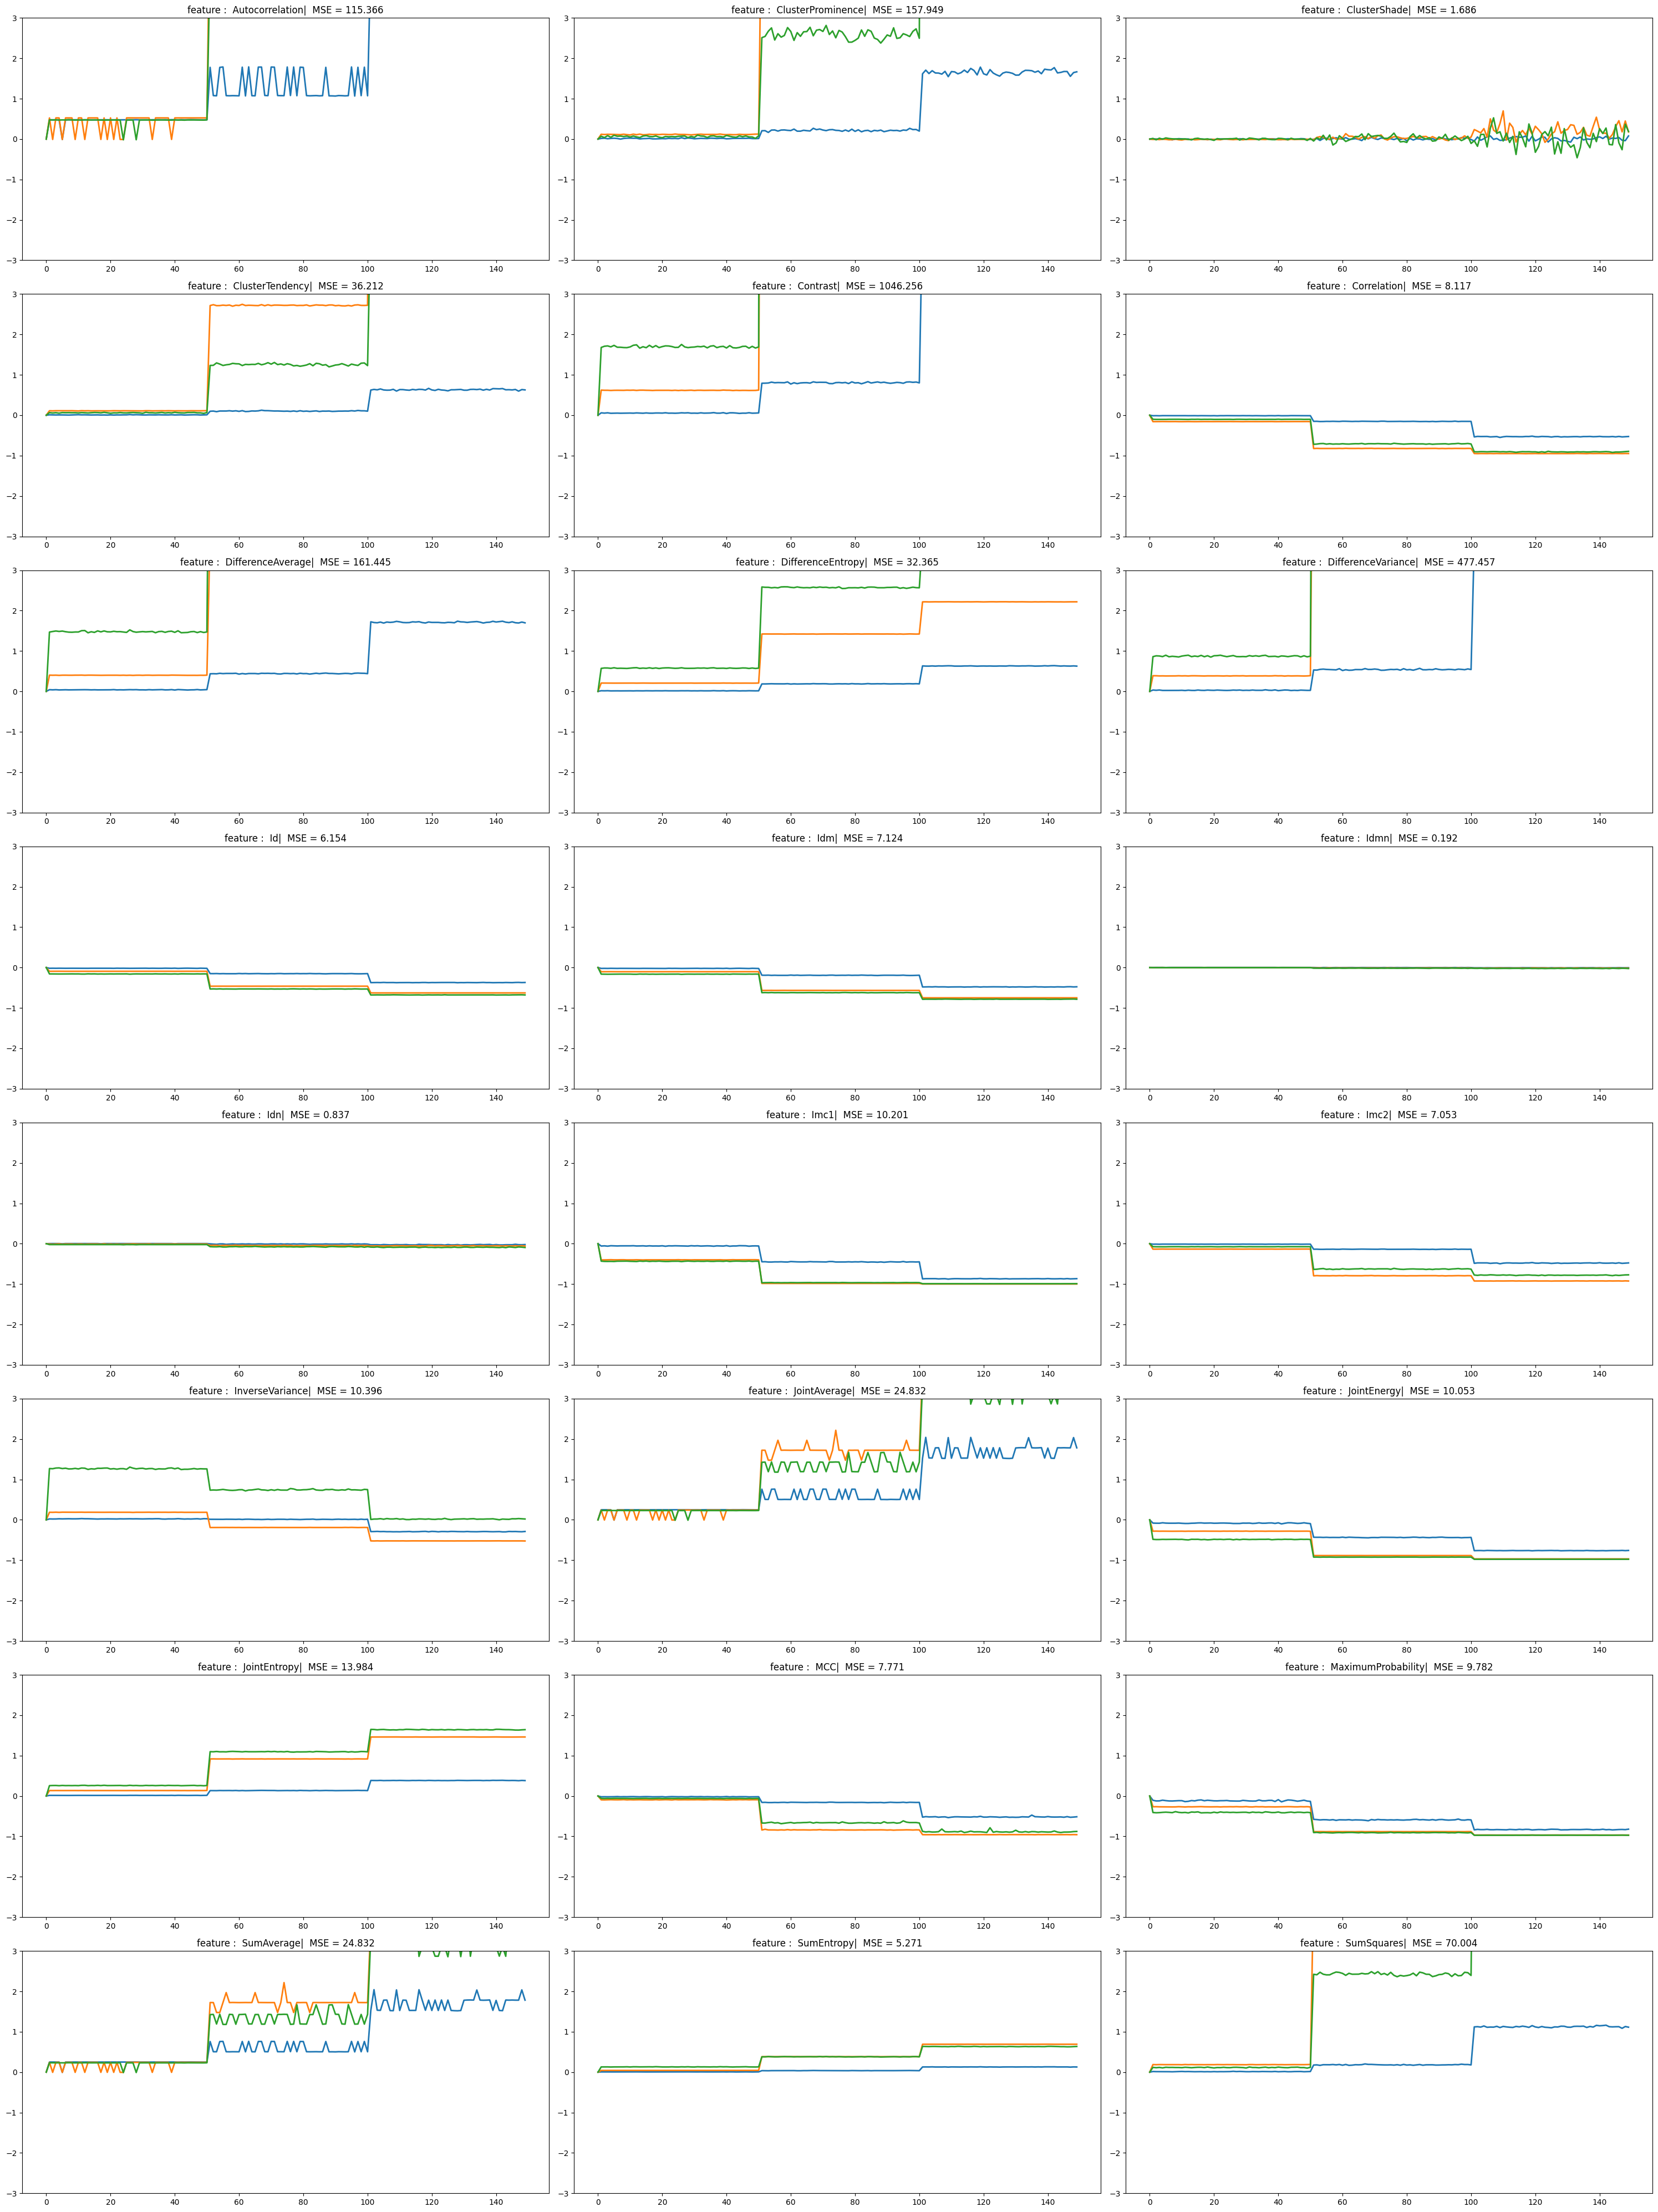

In [56]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))

for i in range(8):
    for j in range(3):
        axs[i, j].plot(noise_err_1[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(noise_err_3[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(noise_err_4[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
    ax.set_ylim(-3, 3)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## variance on noise sigma_b = 5


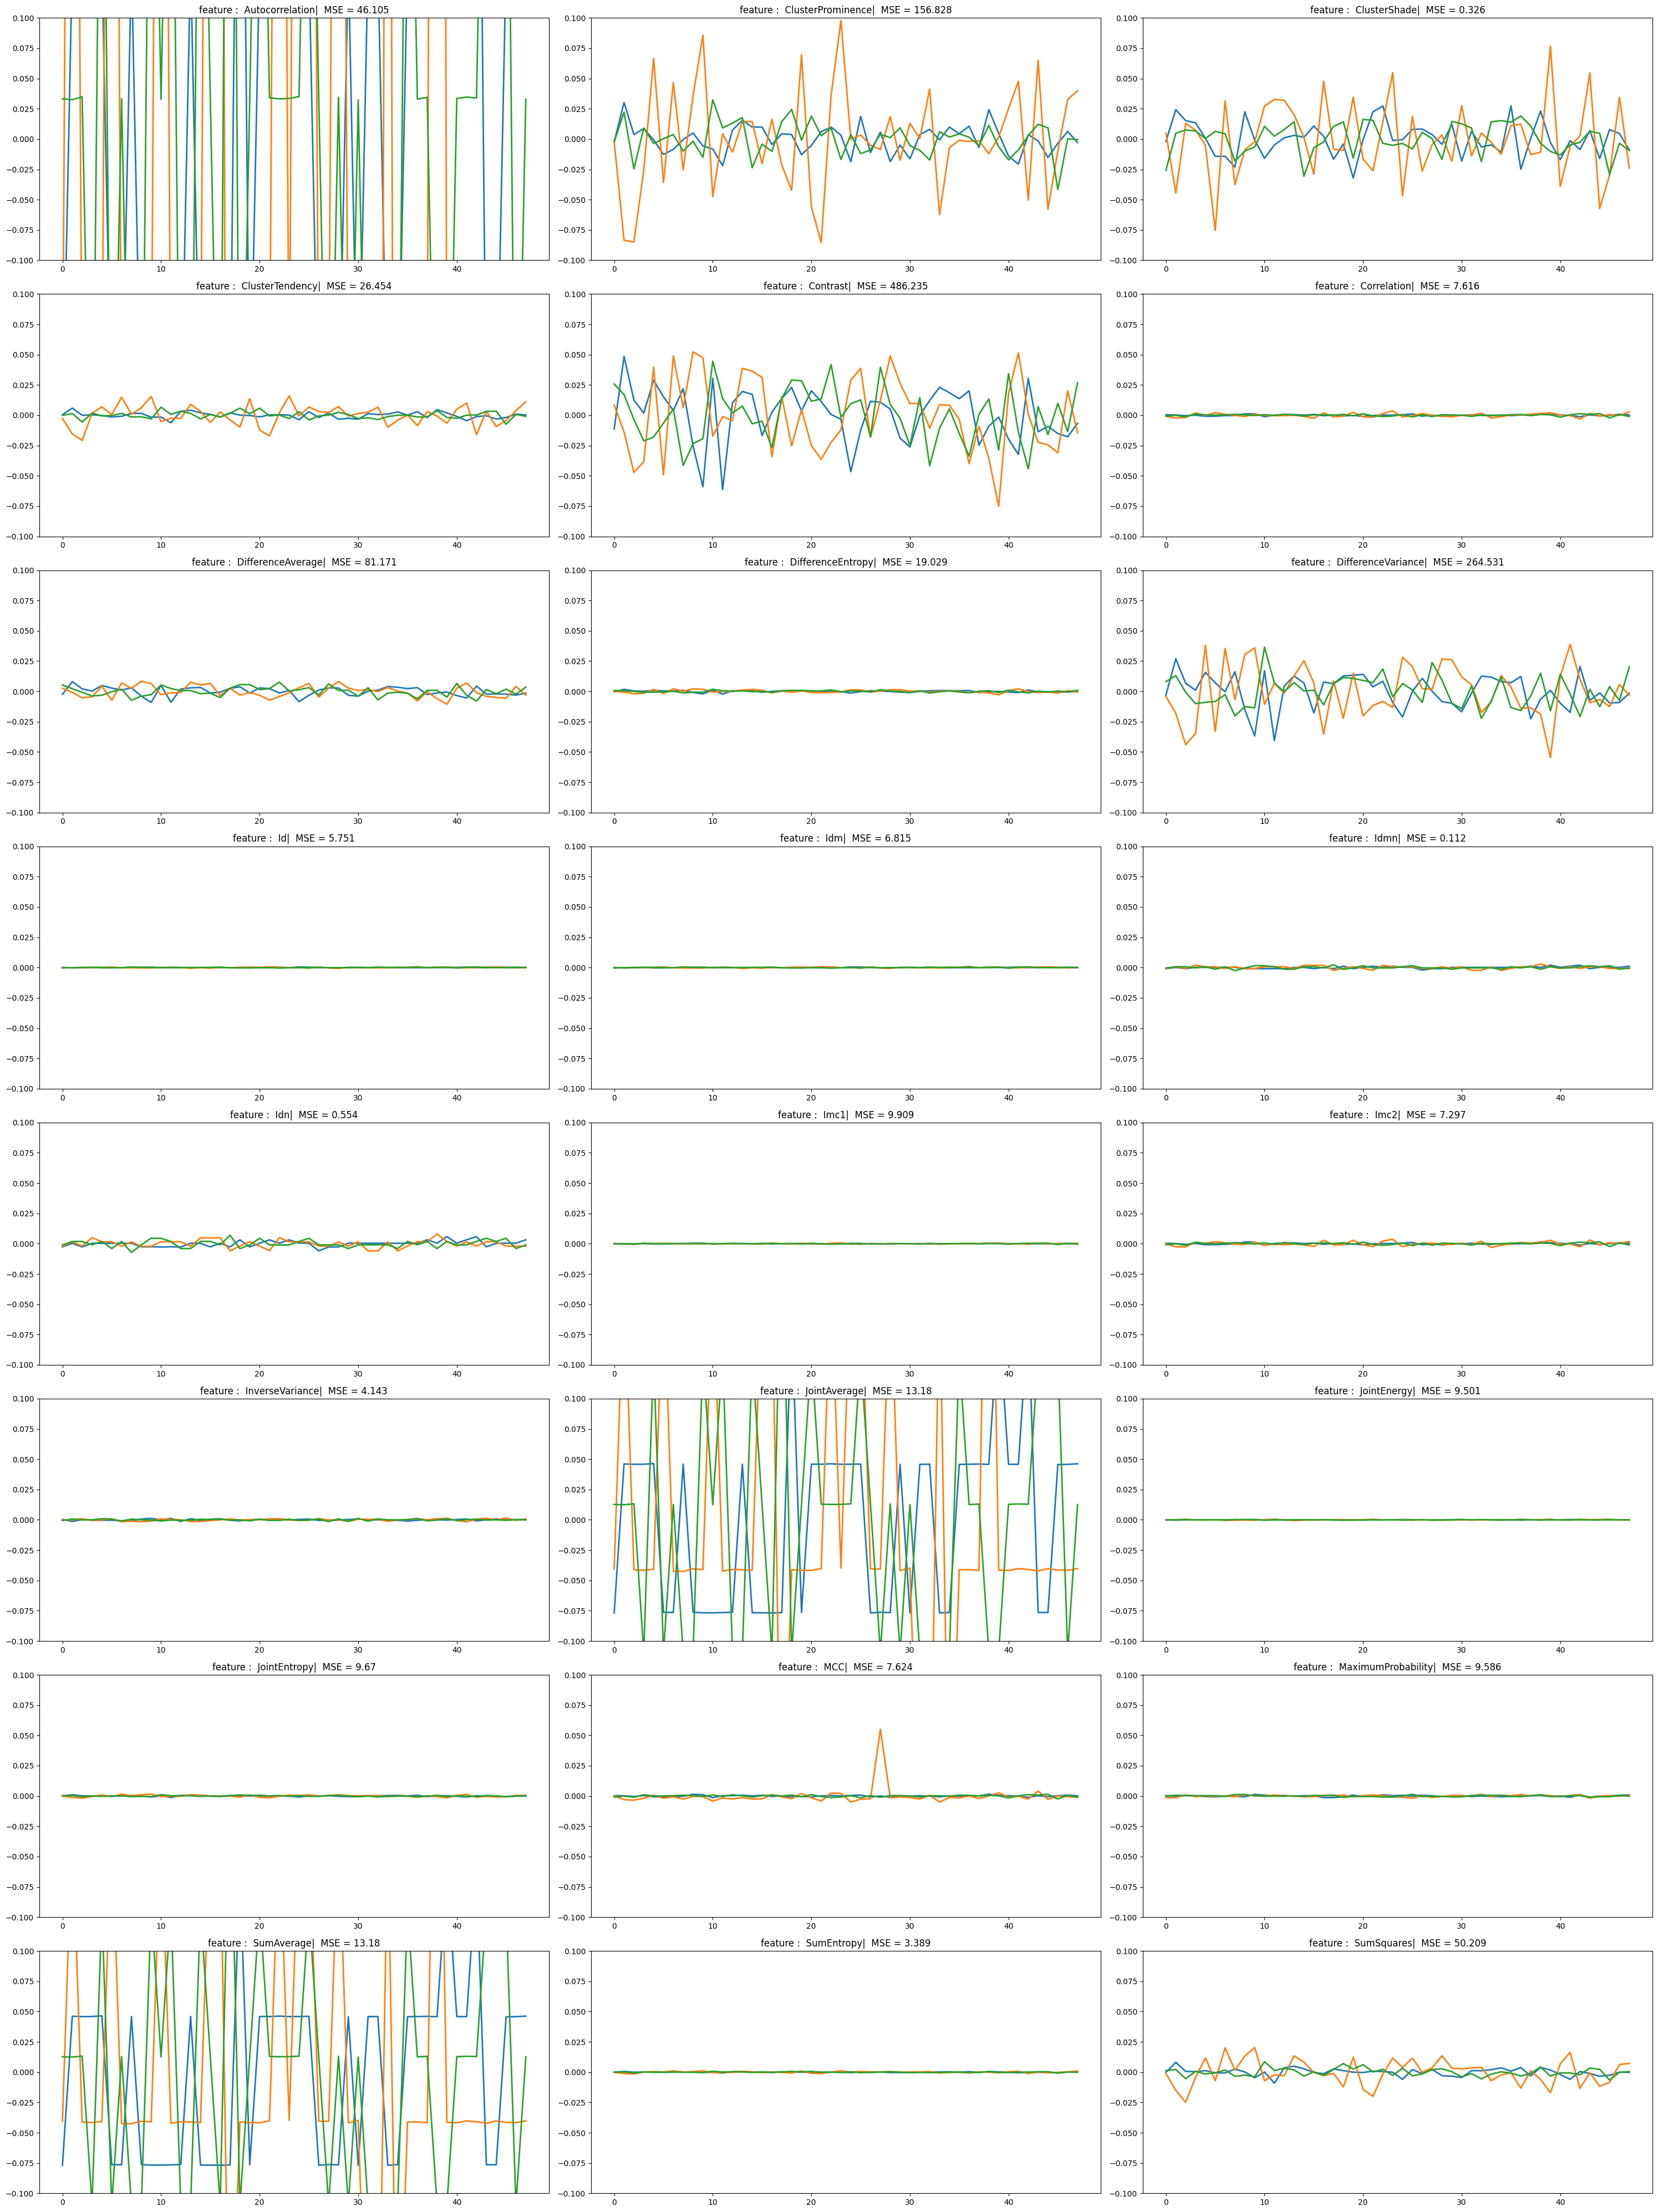

In [ ]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (noise_err_1[51:99,3*i+j] - np.mean(noise_err_1[51:99,3*i+j]) )  , linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_3[51:99,3*i+j] - np.mean(noise_err_3[51:99,3*i+j])  ),  linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_4[51:99,3*i+j] - np.mean(noise_err_4[51:99,3*i+j]) ), linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-0.1, 0.1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Blur Stability

In [ ]:
im_flou1 = flou(im1, kernel_size=3)
im_flou2 = flou(im1, kernel_size=5)

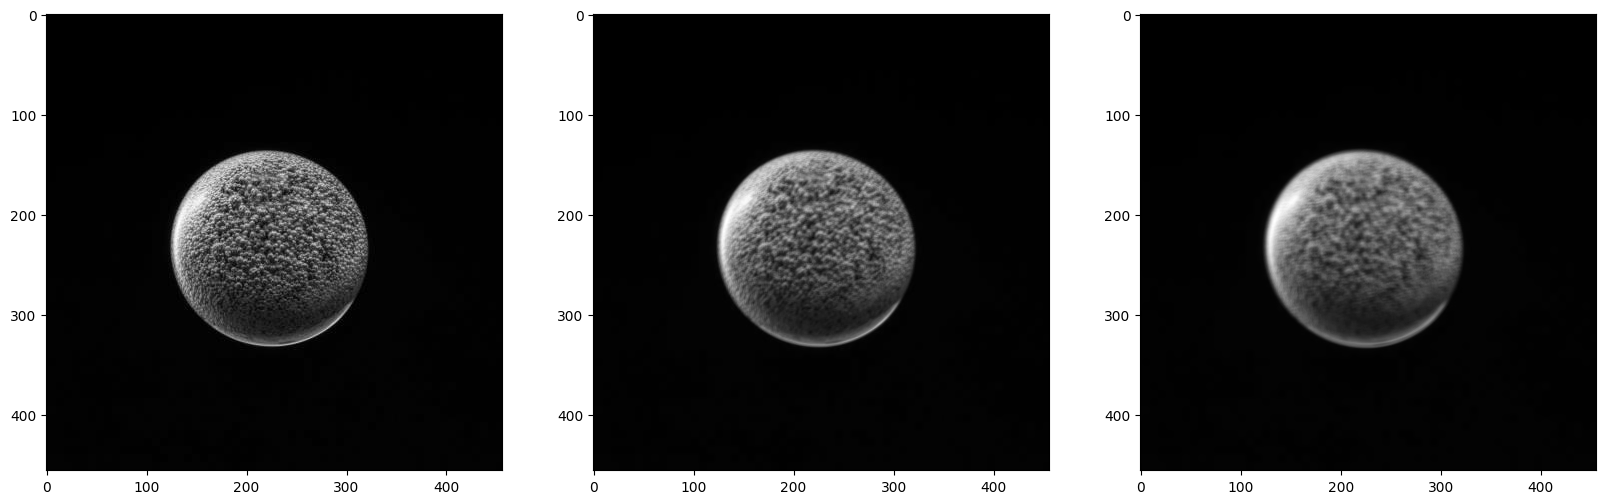

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20, 20))

# Now, you can plot your data on each subplot
axs[0].imshow(im1, cmap = 'gray')

axs[1].imshow(im_flou1, cmap = 'gray')

axs[2].imshow(im_flou2, cmap = 'gray')



### Stabilité par Flou:

In [ ]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_1 = np.array([(features_blurred[i] - features)/features for i in range(100)])
blurr_MSE_1   = [mse(blurr_error_1[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_3 = np.array([(features_blurred[i] - features)/features for i in range(100)])
blurr_MSE_3   = [mse(blurr_error_3[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im4_ITK, mask4_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_4 = np.array([(features_blurred[i] - features)/features for i in range(100)])
blurr_MSE_4   = [mse(blurr_error_4[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

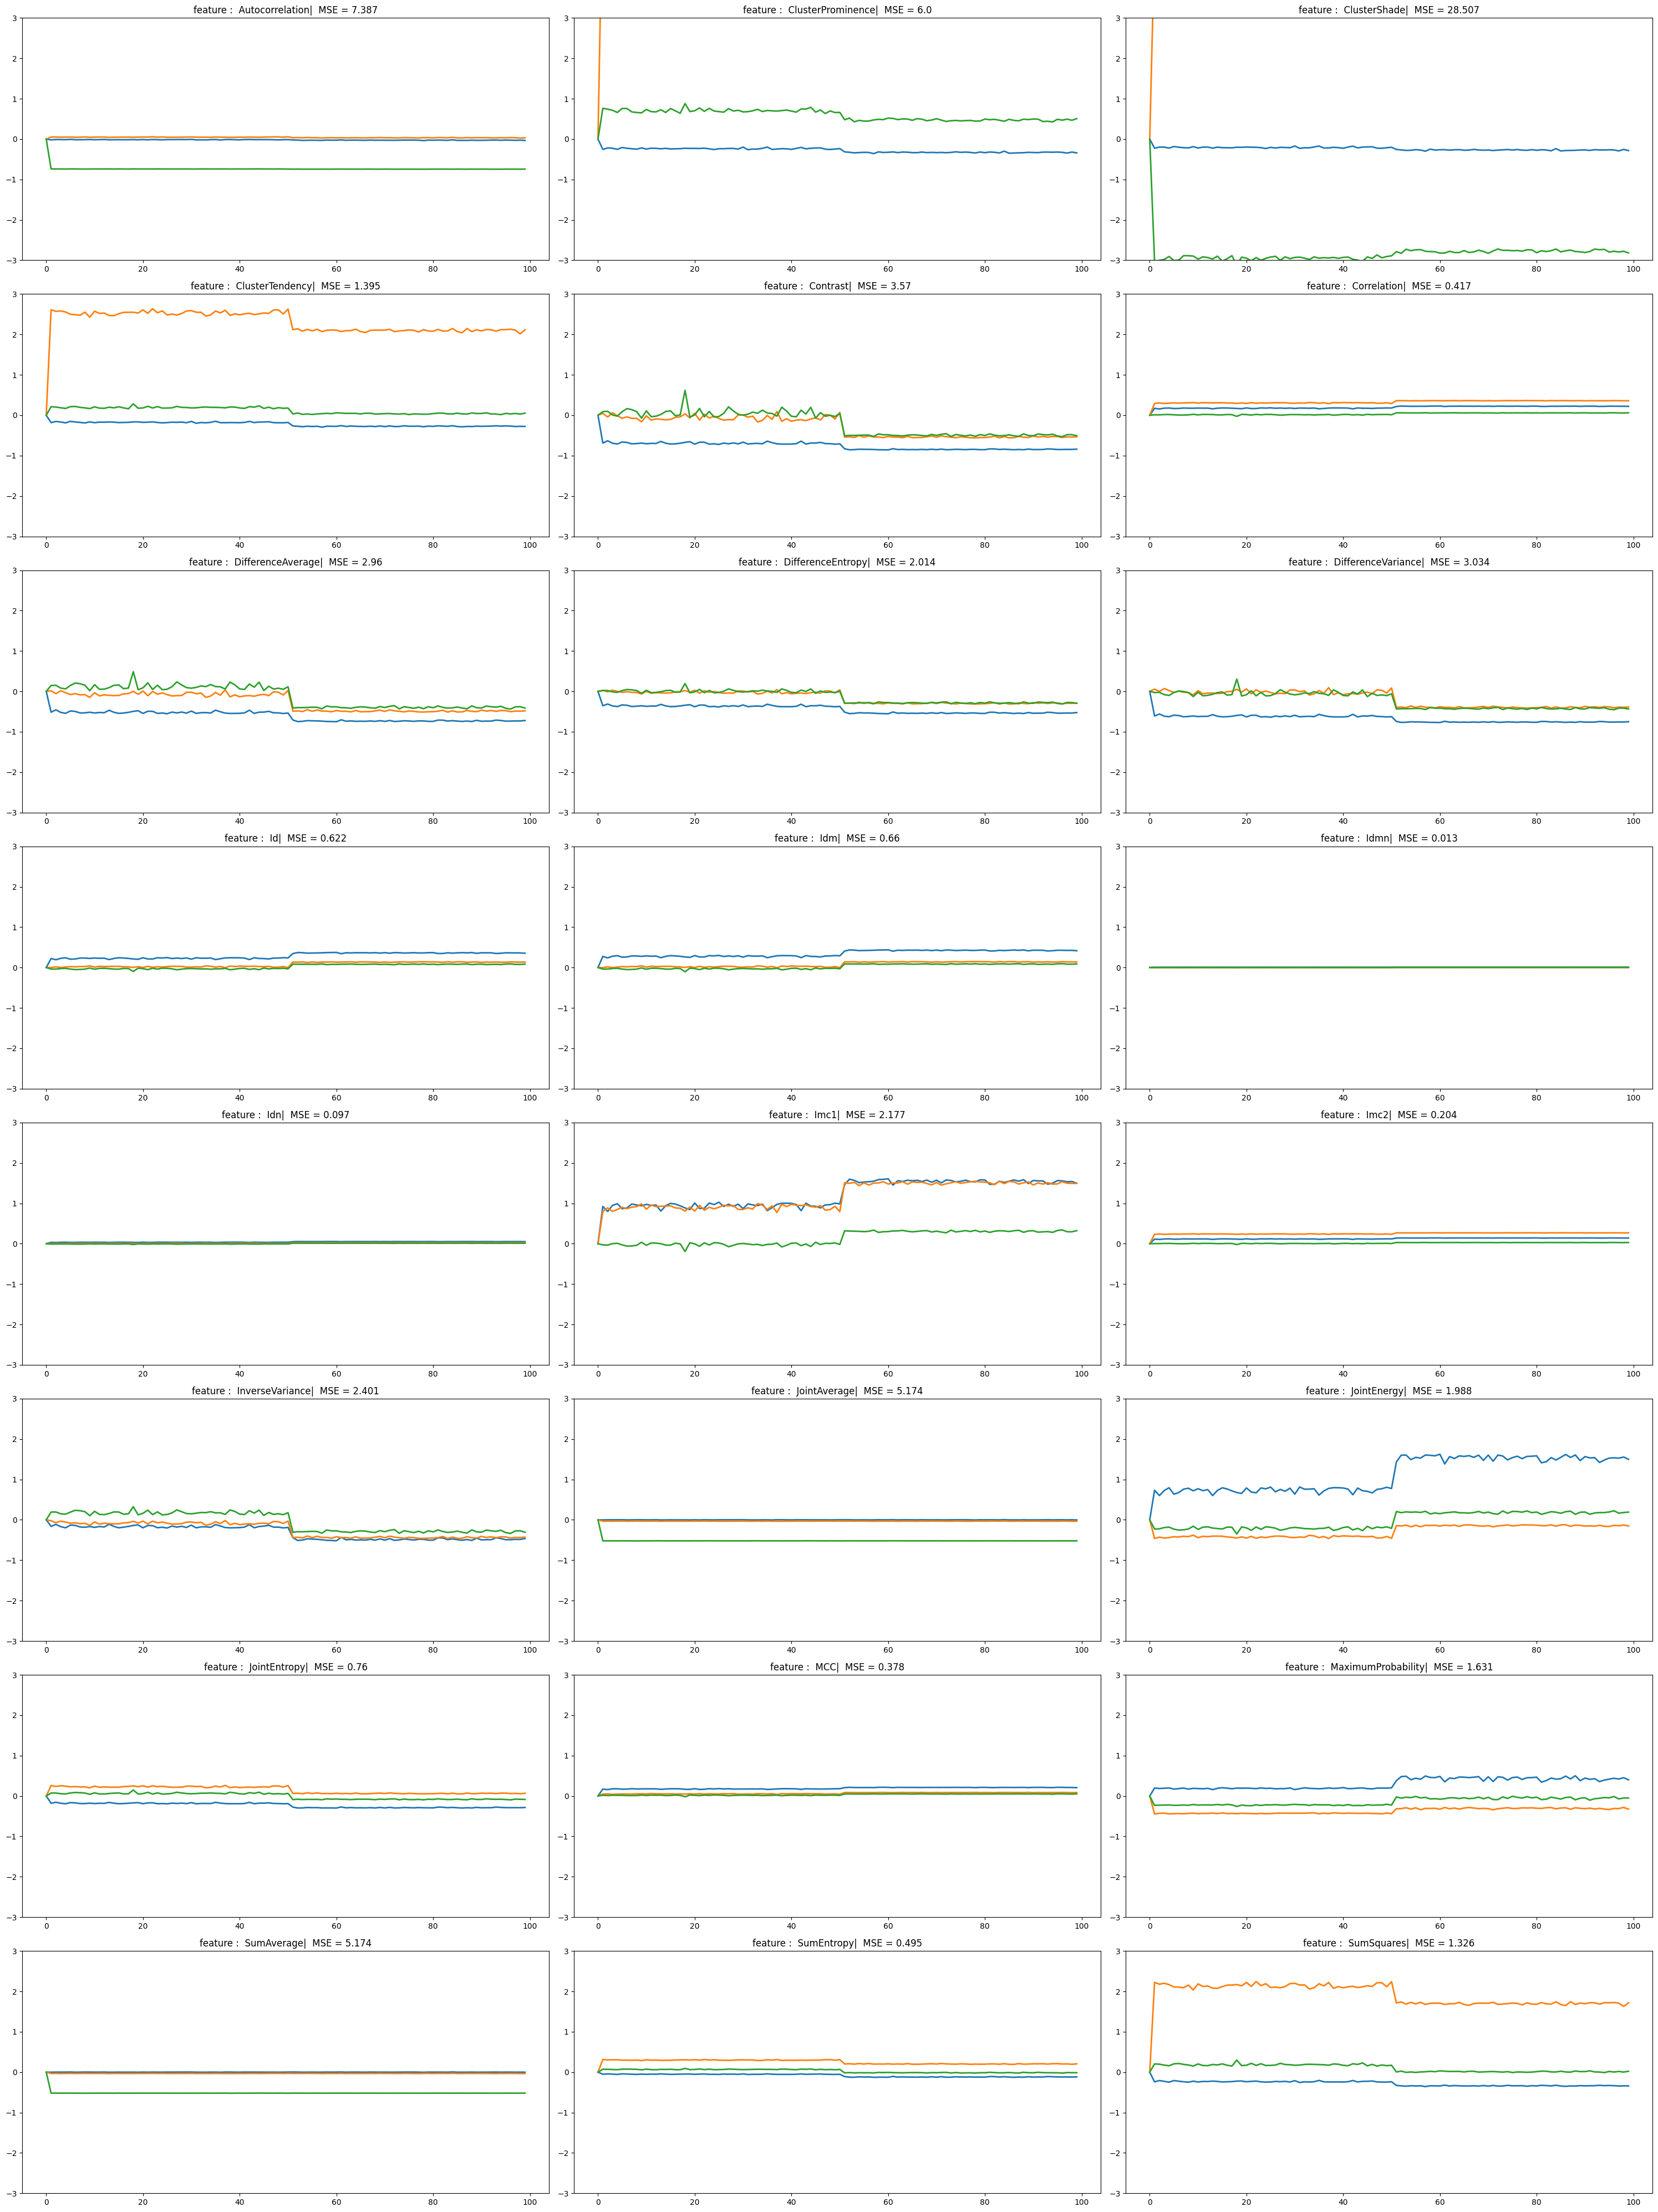

In [ ]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot(blurr_error_1[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_3[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_4[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
    ax.set_ylim(-3, 3)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

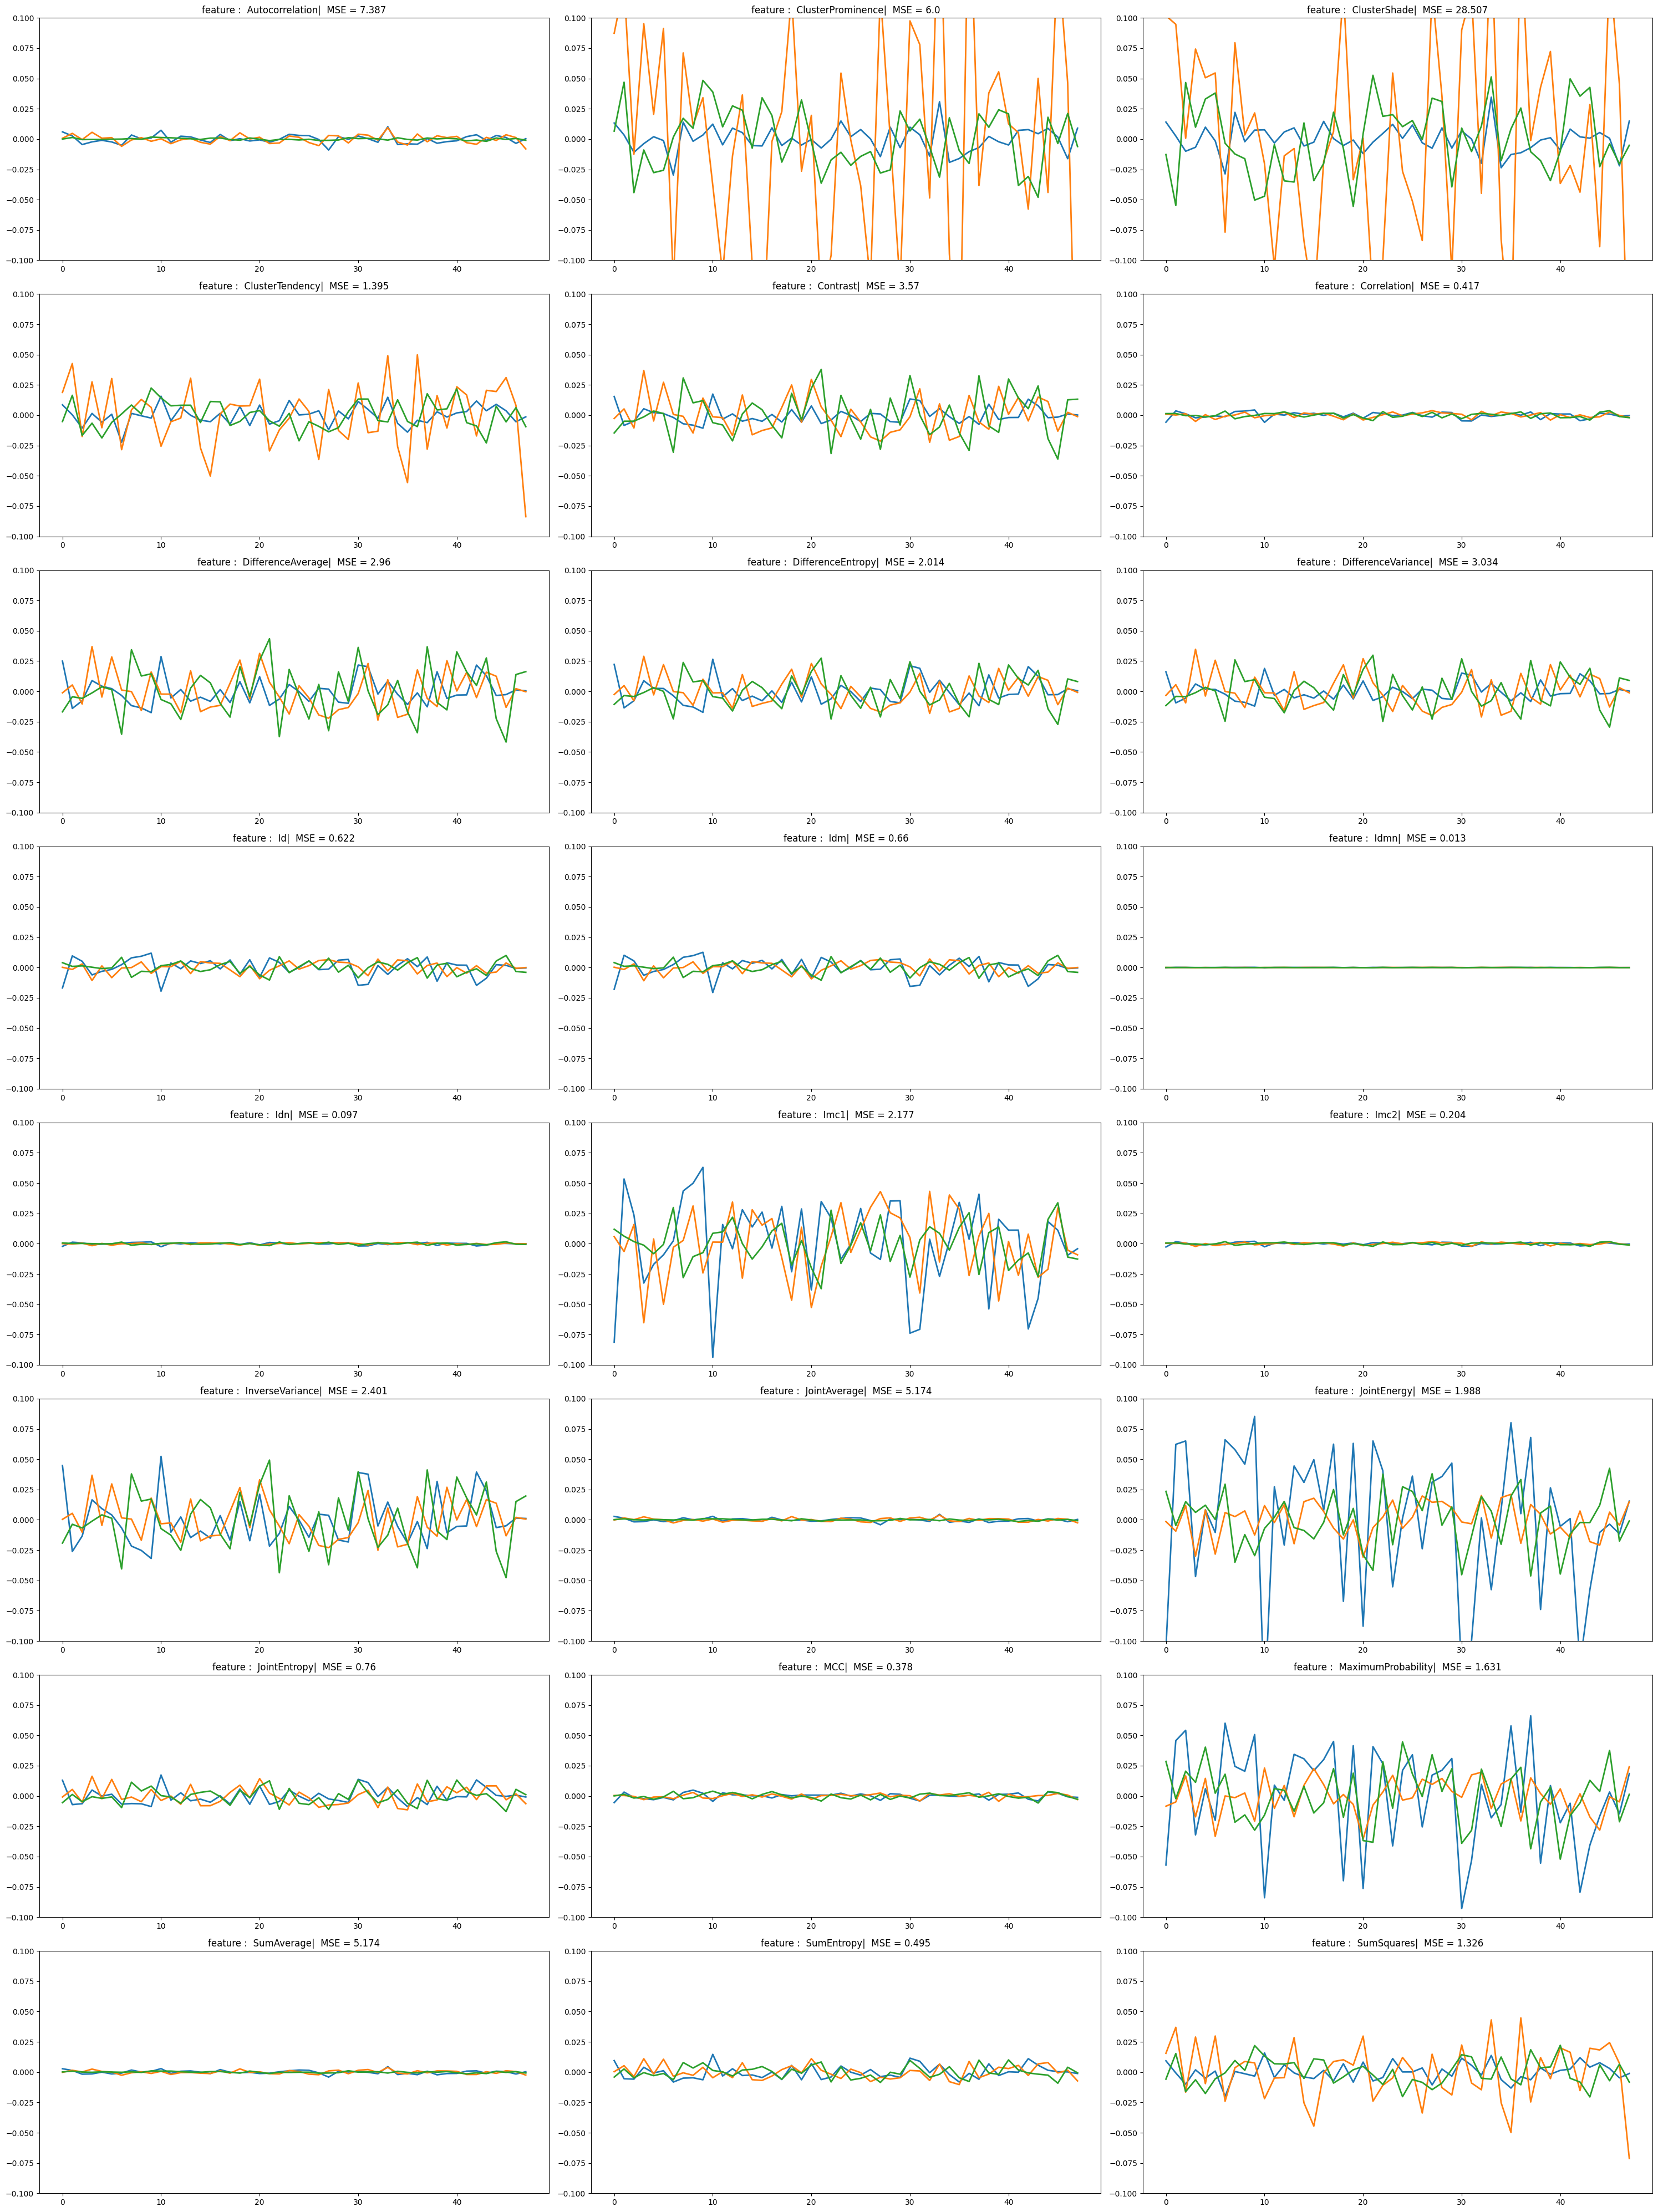

In [ ]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (blurr_error_1[51:99,3*i+j] - np.mean(blurr_error_1[51:99,3*i+j]) )  , linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_3[51:99,3*i+j] - np.mean(blurr_error_3[51:99,3*i+j])  ),  linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_4[51:99,3*i+j] - np.mean(blurr_error_4[51:99,3*i+j]) ), linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-0.1, 0.1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()